In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
df = pd.read_csv('supply_chain_data.csv')
df.head()

,Product type,SKU,Price,Availability,Number of products sold,Revenue generated,Customer demographics,Stock levels,Lead times,Order quantities,...,Location,Lead time,Production volumes,Manufacturing lead time,Manufacturing costs,Inspection results,Defect rates,Transportation modes,Routes,Costs
0,haircare,SKU0,69.808006,55,802,8661.996792,Non-binary,58,7,96,...,Mumbai,29,215,29,46.279879,Pending,0.226410,Road,Route B,187.752075
1,skincare,SKU1,14.843523,95,736,7460.900065,Female,53,30,37,...,Mumbai,23,517,30,33.616769,Pending,4.854068,Road,Route B,503.065579
2,haircare,SKU2,11.319683,34,8,9577.749626,Unknown,1,10,88,...,Mumbai,12,971,27,30.688019,Pending,4.580593,Air,Route C,141.920282
3,skincare,SKU3,61.163343,68,83,7766.836426,Non-binary,23,13,59,...,Kolkata,24,937,18,35.624741,Fail,4.746649,Rail,Route A,254.776159
4,skincare,SKU4,4.805496,26,871,2686.505152,Non-binary,5,3,56,...,Delhi,5,414,3,92.065161,Fail,3.145580,Air,Route A,923.440632


In [ ]:
target = 'Number of products sold'
y = df[target]

df = df.drop(['SKU', 'Revenue generated', 'Routes', 'Supplier name', 'Location'], axis=1)

In [ ]:
X = df.drop(target, axis=1)

numeric_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

X_processed = preprocessor.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [ ]:
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
model = Sequential([
    LSTM(64, activation='relu', input_shape=(1, X_train_reshaped.shape[2]),
         return_sequences=True, kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    LSTM(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1)
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 64)               │          24,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,825 (147.75 KB)

 Trainable params: 37,825 (147.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train_reshaped, y_train,
    validation_data=(X_test_reshaped, y_test),
    epochs=250,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 320798.4375 - mae: 475.9528 - val_loss: 337622.0938 - val_mae: 492.1284
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 307813.5625 - mae: 464.7629 - val_loss: 337595.7812 - val_mae: 492.1025
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 288195.1250 - mae: 442.4659 - val_loss: 337567.6250 - val_mae: 492.0746
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 287069.4688 - mae: 445.8611 - val_loss: 337536.8125 - val_mae: 492.0441
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 309366.2188 - mae: 463.6440 - val_loss: 337501.5000 - val_mae: 492.0091
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 306322.5938 - mae: 466.2353 - val_loss: 337460.6875 - val_mae: 491.9686
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 312597.5000 - mae: 468.0956 - val_loss: 337413.0938 - val_mae: 491.9211
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 284769.3438 - mae: 441.1955 - val

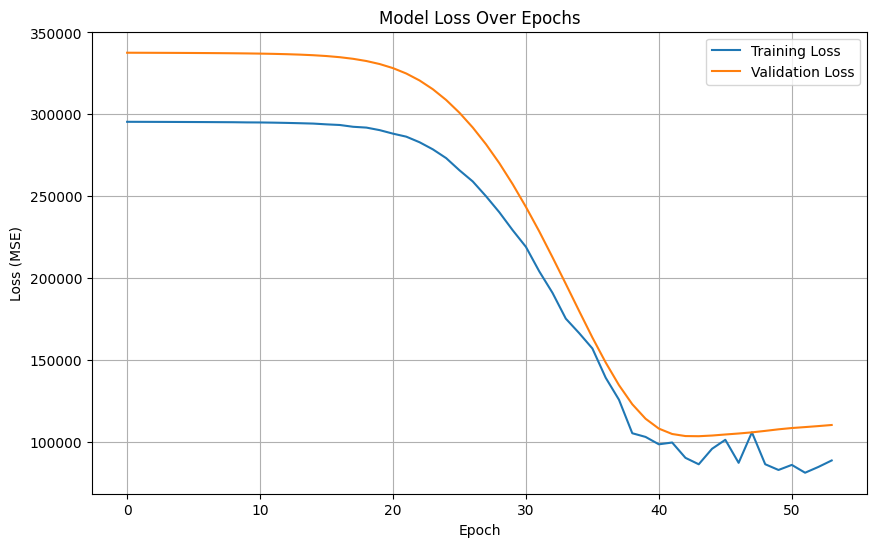

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

plt.savefig('loss_curve.png')
plt.show()

In [ ]:
model.save('supply_chain_lstm_model.keras')

import joblib
joblib.dump(preprocessor, 'preprocessor.pkl')

['preprocessor.pkl']

In [ ]:
new_data_1 = {
    "Product type": "skincare",
    "Price": 45.99,
    "Availability": 80,
    "Customer demographics": "Female",
    "Stock levels": 40,
    "Lead times": 10,
    "Order quantities": 50,
    "Shipping times": 3,
    "Shipping carriers": "Carrier A",
    "Shipping costs": 5.75,
    "Lead time": 15,  # Note: Separate from "Lead times" (if intentional in your data)
    "Production volumes": 300,
    "Manufacturing lead time": 20,
    "Manufacturing costs": 30.50,
    "Inspection results": "Pass",
    "Defect rates": 0.5,
    "Transportation modes": "Road",
    "Costs": 123
}

new_data_2 = {
    "Product type": "haircare",
    "Price": 25.50,
    "Availability": 60,
    "Customer demographics": "Non-binary",
    "Stock levels": 20,
    "Lead times": 7,
    "Order quantities": 70,
    "Shipping times": 5,
    "Shipping carriers": "Carrier B",
    "Shipping costs": 8.20,
    "Lead time": 12,
    "Production volumes": 450,
    "Manufacturing lead time": 15,
    "Manufacturing costs": 20.75,
    "Inspection results": "Pending",
    "Defect rates": 1.2,
    "Transportation modes": "Air",
    "Costs": 543
}

new_data_3 = {
    "Product type": "cosmetics",
    "Price": 75.25,
    "Availability": 95,
    "Customer demographics": "Male",
    "Stock levels": 100,
    "Lead times": 5,
    "Order quantities": 200,
    "Shipping times": 2,
    "Shipping carriers": "Carrier C",
    "Shipping costs": 12.99,
    "Lead time": 8,
    "Production volumes": 600,
    "Manufacturing lead time": 10,
    "Manufacturing costs": 50.00,
    "Inspection results": "Fail",
    "Defect rates": 2.8,
    "Transportation modes": "Sea",
    "cost": 345
}

In [ ]:
import pandas as pd

# Preprocess new data
input_df = pd.DataFrame([new_data_1])
processed_input = preprocessor.transform(input_df)
reshaped_input = processed_input.reshape(1, 1, processed_input.shape[1])

# Predict
predicted_demand = model.predict(reshaped_input)[0][0]
restock = max(0, int(predicted_demand - new_data_1["Stock levels"]))

print(f"Predicted Restock Quantity: {restock}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step
Predicted Restock Quantity: 339
